In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")     

Using device: cuda


In [2]:
dim = 784  # e.g. 28*28 images flattened
r = 25     # bottleneck / testing rank

numToySamples = 10000
toy_mean = 0.0
toy_var = 0.05
toy_std = toy_var ** 0.5

# Generate toy data samples
X = torch.randn(dim, numToySamples, device=device) * toy_std + toy_mean

# Compute empirical mean (mu_X) BEFORE centering
mu_X = X.mean(dim=1, keepdim=True)  # (dim,1)
X_centered = X - mu_X  # (dim, numSamples)
gammaX = torch.cov(X_centered, correction=1) + 1e-5 * torch.eye(dim, device=device)

# Condition number of gammaX
cond_gammaX = torch.linalg.cond(gammaX)
print(f"Condition number of gammaX: {cond_gammaX:.2e}")

# Cholesky factorization: gammaX = K_X @ K_X.T
K_X = torch.linalg.cholesky(gammaX)  # (dim, dim)

# Perform SVD of K_X as in proof
U, D, Vh = torch.linalg.svd(K_X)  # K_X = U D V^T

# Construct optimal rank-r projection matrix A_r = U_r U_r^T
U_r = U[:, :r]  # top r left singular vectors
A_r = U_r @ U_r.T

# Optimal bias vector: b = (I - A_r) mu_X
b = (torch.eye(dim, device=device) - A_r) @ mu_X

# Condition number of A_r
cond_A_r = torch.linalg.cond(A_r)
print(f"Condition number of A_r (rank-{r} projection): {cond_A_r:.2e}")

# =============================================================================
# Theoretical error: average per-sample L2 discrepancy
# =============================================================================
X_recon = A_r @ X_centered + b  # Reconstruct each sample

# Compute difference and per-sample L2 error
diffs_opt = X_recon - X_centered
rel_error_theory_train = torch.norm(diffs_opt, dim=0).mean().item()  # average over samples

print(f"Theoretical average per-sample L2 training error: {rel_error_theory_train:.4f}")


Condition number of gammaX: 3.11e+00
Condition number of A_r (rank-25 projection): 5.31e+09
Theoretical average per-sample L2 training error: 6.1000


Final average per-sample L2 training error (learned): 6.1132


C:\Users\alexr\AppData\Local\Temp\ipykernel_37280\1133033597.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


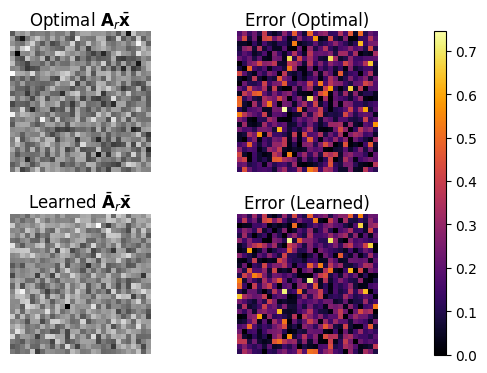

In [4]:
# %%
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from torch import nn, optim

# ── Toy dataset setup (assuming X, X_centered, mu_X, gammaX, A_r, b already defined) ──
# If not already run, execute the toy dataset cell above first.

batch_size = 128
num_epochs = 350

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=True)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Instantiate model, optimizer, and loss
model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Prepare training data tensors (using centered data as input/output)
X_tensor = X_centered.T  # Shape (numSamples, dim)
Y_tensor = X_centered.T

# Training loop
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y_tensor)
    target  = X_tensor

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight
        diffs = A_learned @ X_centered + model.decoder.bias.view(-1,1) - X_centered
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()
        train_errors.append(avg_l2_err)

print(f"Final average per-sample L2 training error (learned): {train_errors[-1]:.4f}")

# =============================================================================
# Compact 2×2 gallery comparing Optimal vs Learned reconstructions
# =============================================================================
everforest_colors = [
    "#2d353b", "#3d484d", "#4f585e", "#566358", "#5a6f47",
    "#7a9c58", "#a7c080", "#dbbc7f", "#e69875", "#e67e80", "#dc5456"
]
everforest_cmap = LinearSegmentedColormap.from_list(
    'everforest_blend',
    everforest_colors,
    N=256
)

# Example sample index for plotting
idx = 7184 % numToySamples

# Prepare images for plotting with .detach() fix
true_img  = (X_centered[:, idx] + mu_X.squeeze()).detach().view(28,28).cpu()
opt_img   = (A_r @ X_centered + b)[:, idx].detach().view(28,28).cpu()
learn_img = (A_learned @ X_centered + model.decoder.bias.view(-1,1))[:, idx].detach().view(28,28).cpu()

err_opt   = torch.abs(opt_img   - true_img)
err_learn = torch.abs(learn_img - true_img)
err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

# Create 2×2 plot grid (Optimal / Learned + errors)
fig = plt.figure(figsize=(6, 4.2))
gs  = gridspec.GridSpec(
    2, 3,
    width_ratios=[1, 1, 0.06],
    wspace=0.20, hspace=0.30
)

# row 0: Optimal reconstruction + error
ax = fig.add_subplot(gs[0, 0])
ax.imshow(opt_img, cmap='gray')
ax.set_title(r'Optimal $\mathbf{A}_r \bar{\mathbf{x}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(r'Error (Optimal)', pad=4)
ax.axis('off')

# row 1: Learned reconstruction + error
ax = fig.add_subplot(gs[1, 0])
ax.imshow(learn_img, cmap='gray')
ax.set_title(r'Learned $\bar{\mathbf{A}}_r \bar{\mathbf{x}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(r'Error (Learned)', pad=4)
ax.axis('off')

# color-bar
cax = fig.add_subplot(gs[:, 2])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

plt.tight_layout()
#plt.savefig(f"end2endpics/MedMNIST/chestmnist/sample{idx}_{numSamples}_{r}.png")
plt.show()


In [5]:
# ════════════════════════════════════════════════════════════════════════════
# MULTI-DATASET RANK SWEEP – TOY AFFINE LINEAR
#   • Computes Bayes–optimal rank-r projection matrix A_r and bias b
#   • Learns encoder/decoder + bias using linear autoencoder
#   • Saves results to pickles (optional)
# ════════════════════════════════════════════════════════════════════════════

import os, pickle, torch
from collections import defaultdict
from torch import nn, optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ── Toy dataset parameters ──────────────────────────────────────────────────
dim = 784
numToySamples = 10000
toy_mean = 0.0
toy_var = 0.05
toy_std = toy_var ** 0.5

# Generate toy dataset
X = torch.randn(dim, numToySamples, device=device) * toy_std + toy_mean
mu_X = X.mean(dim=1, keepdim=True)
X_c = X - mu_X  # mean-centered

# ── Linear Autoencoder model ────────────────────────────────────────────────
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=True)
    def forward(self, x):
        return self.decoder(self.encoder(x))

criterion = nn.MSELoss()

# ── Sweep over ranks ────────────────────────────────────────────────────────
ranks = list(range(25, 401, 25))
theory_err, learned_err = [], []

# Empirical covariance and Cholesky factorization
gammaX = (X_c @ X_c.T) / (numToySamples - 1) + 1e-5 * torch.eye(dim, device=device)
K_X = torch.linalg.cholesky(gammaX)
U, D, Vh = torch.linalg.svd(K_X)

for r in ranks:
    # --- Bayes-optimal projection matrix A_r -------------------------------
    U_r = U[:, :r]
    A_r = U_r @ U_r.T
    b_r = (torch.eye(dim, device=device) - A_r) @ mu_X

    # Optimal reconstruction error
    X_opt = A_r @ X_c + b_r
    diffs_opt = X_opt - X_c
    avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
    theory_err.append(avg_l2_opt)

    # --- Linear Autoencoder learning ---------------------------------------
    ae = LinearAutoencoder(dim, r).to(device)
    opt = optim.Adam(ae.parameters(), lr=1e-3)

    num_epochs = 350
    for _ in range(num_epochs):
        opt.zero_grad()
        out = ae(X_c.T)
        loss = criterion(out, X_c.T)
        loss.backward()
        opt.step()

    with torch.no_grad():
        W_enc = ae.encoder.weight.detach().cpu()
        W_dec = ae.decoder.weight.detach().cpu()
        b_dec = ae.decoder.bias.detach().cpu() if ae.decoder.bias is not None else torch.zeros(dim)
        A_learned = W_dec @ W_enc

        X_learn = A_learned.to(device) @ X_c + b_dec.to(device).unsqueeze(1)
        diffs_learn = X_learn - X_c
        avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
    learned_err.append(avg_l2_learn)

Using device: cuda


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alexr\AppData\Local\Temp\ipykernel_37280\2157761637.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Average $\ell_2$ Error vs. Rank (Affine Linear)')


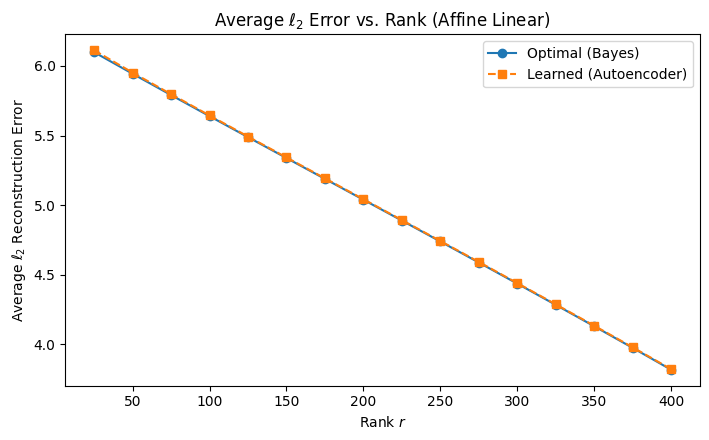

In [9]:
# ── Final plot comparing optimal vs learned errors ──────────────────────────
plt.figure(figsize=(7.2, 4.5))
plt.plot(ranks, theory_err, 'o-', label="Optimal (Bayes)")
plt.plot(ranks, learned_err, 's--', label="Learned (Autoencoder)")
plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
#plt.yscale('log')
plt.title('Average $\ell_2$ Error vs. Rank (Affine Linear)')
plt.legend()
plt.tight_layout()
plt.show()